# M3 Reconstruction
### Using the 3 highest P_{T} jets Lorentz Vector to construct and invariant mass. Known as M3 Reconstruction
By Zach Shelton
01/25/2021

In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan


In [201]:
from __future__ import print_function, division
import uproot
import numpy as np
#Make sure to install both old awkward0 and new awkward1(referred to now as awkward)
import awkward1 as ak
import awkward0 as ak0
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import awkward
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
def m3_recon(tree):
    comb= ak.combinations(tree,n=3,axis=1,fields=['j1','j2','j3'])
    trijets= comb.j1+comb.j2+comb.j3
    recon =ak.max(trijets,axis=1)
    reconfinal=np.sqrt(recon.t*recon.t-recon.x*recon.x-recon.y*recon.y-recon.z*recon.z)
    #MISUSE/CONFUSION:
    #for some reason None values are being placed in array
    #So I reconstructed the mass "manually"
    list1= ak.to_numpy(reconfinal)
    return list1
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
nEvents=file['hEvents'].values[0]+file['hEvents'].values[2]

## Note: It seems the Jet columns are sorted from greatest p_t to smallest p_t
Feel free to test, but it seems to be my observation, choosing the 1st, 2nd or 3rd jet via index should remove the issue of it being a coffea sorting artifact or procedure

In [3]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events =NanoEventsFactory.from_root(files,schemaclass=HackSchema).events()


In [4]:
#Condensing All Cuts to a single Cell
tight_jets=events.Jet
print(tight_jets)
jetSel = ak.num(tight_jets[((tight_jets.pt>30)&(tight_jets.eta<2.4)&(tight_jets.eta>-2.4))],axis=1)>=3
jetSelection=(jetSel&(ak.num(tight_jets.btagCSVV2>.4184)>=1))

[[Jet, Jet, Jet, Jet, Jet], [Jet, Jet, ... Jet, Jet, Jet, Jet, Jet, Jet, Jet, Jet]]


In [20]:
print(len(jetSelection))
events.GenJet.partonFlavour

1734354


<Array [[5, -5, 0, -1, 2, ... -5, 21, 5, 1]] type='1734354 * var * int32[paramet...'>

In [6]:
recon_precuts = m3_recon(tight_jets)

C:\Users\zshel\anaconda3\envs\top_tag1\lib\site-packages\awkward1\_connect\_numpy.py:163: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs


In [7]:
#Condensing_all Lepton_cuts
tight_muons = events.Muon
muonsel=ak.num(tight_muons[((tight_muons.pt>30)&(abs(tight_muons.eta)<2.4))],axis=1)==1
tight_electrons= events.Electron
electronsel=ak.num(tight_electrons[((tight_electrons.pt>35)&(abs(tight_electrons.eta)<2.4))],axis=1)==1
leptonsel=(muonsel|electronsel)
print(leptonsel)

[True, True, True, True, False, True, True, ... True, True, True, True, True, True]


In [8]:
jetlepselmask = (jetSelection&leptonsel)
print((jetlepselmask))
print(events[jetlepselmask])
final=events[jetlepselmask]
postcuts_m3=m3_recon(events[jetlepselmask].Jet)

[True, True, True, True, False, True, True, ... True, True, True, True, True, True]
[<event 1:50992:8498517>, <event 1:50992:8498507>, ... <event 1:641843:106973897>]


In [9]:
print(len(final))

1381189


<AxesSubplot:xlabel='p_{t}', ylabel='p_t Comparison'>

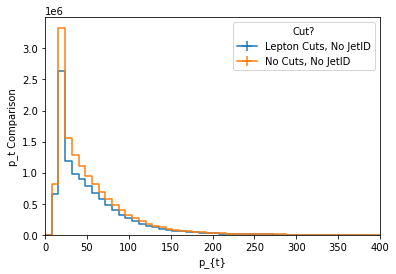

In [10]:
import coffea.hist as hist
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("p_t","p_{t}",50,0,400)
histogram= hist.Hist("p_t Comparison",cat,bins)
histogram.fill(cut="No Cuts, No JetID",p_t=ak.flatten(events.Jet.pt))
#histogram.fill(cut="Simple Cuts, No JetID",p_t=ak.flatten(simplecuts.Jet.pt))
histogram.fill(cut="Lepton Cuts, No JetID",p_t=ak.flatten(events[jetlepselmask].Jet.pt))
hist.plot1d(histogram,overlay='cut')

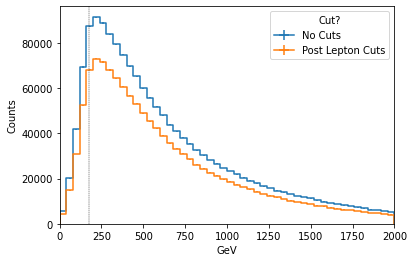

In [11]:
#M3 Reconstruction
import coffea.hist as hist
import matplotlib.pyplot as plt
cat=hist.Cat("cut","Cut?")
bins=hist.Bin("M3","GeV",50,0,2000)
histogram= hist.Hist("Counts",cat,bins)
#histogram.fill(cut="Lepton Cuts",M3=postcuts_m3)
histogram.fill(cut="No Cuts",M3=recon_precuts)
#histogram.fill(cut="Simple p_t and eta cuts",M3=simpcutsrecon)
histogram.fill(cut="Post Lepton Cuts",M3=postcuts_m3)
fig=hist.plot1d(histogram,overlay='cut',density=False)
fig.axvline(173, color='k', linestyle='dashed', linewidth=.4)
#They seem to be identical? Should they be different?

Conclusions?
2/15/21
I find that the density of the M3 reconstruction still matches the original uncut values. 
- Is there missing parameter I am not factoring in?
- Now, it seems I am applying the cuts correctly
- I want to overlay a plot with "correct jets" from the generator
- Neural Network data Prepararation



## What's next?? Worth Including? Are these covered in the CMS Analysis notes?
- Jet TightID
- More 
- Particle Values
- Delta R

Wrap into Coffea Executor
Seperate values, weights and triggers
read these into tensors for Keras
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
- Combine old processes together
Should I use Keras or PyTorch?
_______________________________________________________________________________
Running Notes and questions
- Standardizing the "size", tensorflow has a ragged tensor, which is tf's variable size data arrays. I keep getting the following output
    
- Awkward doesn't have native access to ndim? That seems not correct, not sure if its my implementation. 

## Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable

# Coffea Processor to precuts on data, This may be a slow loop as I'll need a 

In [182]:
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
def m3_recon(tree):
    #print(tree[1])
    comb= ak.combinations(tree,n=3,axis=1,fields=['j1','j2','j3'])
    #print(comb[1])
    trijets= comb.j1+comb.j2+comb.j3
    recon =ak.max(trijets,axis=1)
    #print(recon[1])
    reconfinal=np.sqrt(recon.t*recon.t-recon.x*recon.x-recon.y*recon.y-recon.z*recon.z)
    list1= ak.to_numpy(reconfinal)
    return list1
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
class JetPreProcess(processor.ProcessorABC):
    def __init__(self):

        #Declare an axis for the dataset
        dataset_axis = hist.Cat("dataset","Dataset")
        
        #Declare an axis for the muon pt
        pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 50, 0, 200)
        mass_axis= hist.Bin("mass","Mass [GeV]",100,0,1000)

        
        #Utilizing Column Accumulators, the structure of data can be retained utilizing the pad_none function. during conversion to Numpy arrays
        #None values are converted to zeros.
        self._accumulator = processor.dict_accumulator({
            'pre-cuts_M3': hist.Hist("Counts", dataset_axis, mass_axis),
            'post-cuts_M3':hist.Hist("Counts", dataset_axis, mass_axis),
            'pre-cuts_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            'post-cuts_pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'jet_phi':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'jet_eta':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'jet_pt':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'jet_mass':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'genjet_id':processor.column_accumulator(np.ndarray(shape=(1,8)))
        }
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        #####
        #Tight Lepton selection
        #####
        tight_muons = events.Muon
        muonsel=ak.num(tight_muons[((tight_muons.pt>30)&(abs(tight_muons.eta)<2.4))],axis=1)==1
        tight_electrons= events.Electron
        electronsel=ak.num(tight_electrons[((tight_electrons.pt>35)&(abs(tight_electrons.eta)<2.4))],axis=1)==1
        leptonsel=(muonsel|electronsel)
        
        ######
        #Selects Jets with Jet cuts AND at least one b-tagged jet
        ######
        tight_jets=events.Jet
        jetSel = ak.num(tight_jets[((tight_jets.pt>30)&(tight_jets.eta<2.4)&(tight_jets.eta>-2.4))],axis=1)>=3
        jetSelection=(jetSel&(ak.num(tight_jets.btagCSVV2>.4184)>=1))
        #JetSelection and Lepton Selection combined create final "Pre-processed Data"
        f_events=events[(jetSelection&leptonsel)]
        jet_pt=(processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(f_events.Jet.pt,8,clip=True)))))
        output['pre-cuts_M3'].fill(dataset=dataset,mass=m3_recon(events[ak.num(events.Jet)>=3].Jet))
        output['post-cuts_M3'].fill(dataset=dataset,mass=m3_recon(f_events.Jet))
        output['pre-cuts_pt'].fill(dataset=dataset,pt=ak.flatten(events.Jet.pt))
        output['post-cuts_pt'].fill(dataset=dataset,pt=ak.flatten(f_events.Jet.pt))
        output['jet_pt']+=jet_pt
        output['jet_mass']+=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(f_events.Jet.mass,8,clip=True))))
        output['jet_phi']+=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(f_events.Jet.phi,8,clip=True))))
        output['jet_eta']+=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(f_events.Jet.eta,8,clip=True))))
        output['genjet_id']+=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(f_events.GenJet.partonFlavour,8,clip=True))))
        return output

    def postprocess(self, accumulator):
        return accumulator

In [183]:
#Run coffea processor again, this time using the filesetData list
fileset = {
    'tt-bar': [files]
}
outputData = processor.run_uproot_job(
    fileset,
    "Events",
    JetPreProcess(),
    processor.iterative_executor,
    executor_args={"schema": HackSchema,'workers': 8}, 
    chunksize=100000,
)


Processing:   0%|          | 0/17 [00:00<?, ?chunk/s]

In [249]:
outputData['jet_pt'].value[20000]

array([71.25   , 54.34375, 32.90625, 32.625  , 27.71875, 19.90625,
        0.     ,  0.     ])

In [257]:
events.GenJet.partonFlavour

<Array [[5, -5, 0, -1, 2, ... -5, 21, 5, 1]] type='1734354 * var * int32[paramet...'>

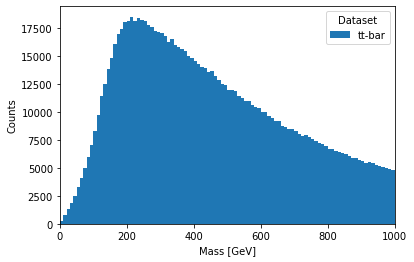

In [238]:
import coffea.hist as hist
import matplotlib.pyplot as plt
#hist.plot1d(outputData['pre-cuts_M3'],overlay='dataset',stack=True)
plt = hist.plot1d(outputData['post-cuts_M3'],overlay='dataset',stack=True)

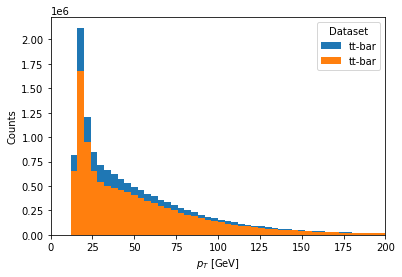

In [188]:
import coffea.hist as hist
import matplotlib.pyplot as plt
hist.plot1d(outputData['pre-cuts_pt'],overlay='dataset',stack=True)
hist.plot1d(outputData['post-cuts_pt'],overlay='dataset',stack=True)
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

In [114]:
import keras
import math
import tensorflow as tf

In [50]:
ML_events = events[jetlepselmask]
comb= ak.combinations(events.Jet,n=3,axis=1,fields=['j1','j2','j3'])

In [ ]:
ML_predata=tf.ragged.constant((ML_events.Jet.pt))